In [1]:
%load_ext autoreload
%autoreload 2

# Calculate distances and find neighbors

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import poligrain as plg

## Point-to-point distances

### Get PWS dataset

In [3]:
!curl -OL https://github.com/OpenSenseAction/training_school_opensene_2023/raw/main/data/pws/data_PWS_netCDF_AMS_float.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10.7M  100 10.7M    0     0  3357k      0  0:00:03  0:00:03 --:--:-- 3723k


In [4]:
ds_pws = xr.open_dataset("data_PWS_netCDF_AMS_float.nc")

# fix some issues with this dataset
ds_pws["time"] = pd.to_datetime(ds_pws.time.data, unit="s")
ds_pws["lon"] = ("id", ds_pws.lon.data)
ds_pws["lat"] = ("id", ds_pws.lat.data)

### Project cooridnates from lon-lat to UTM zone for Europe

Info on the UTM zone 32N projection `'EPSG:25832'` that is used can be found [here](https://epsg.io/25832#google_vignette)

Note that `plg.spatial.project_coordinates` can also use a different source coordinate system, but its default is WGS 84 (lon and lat in degrees), which is `'EPSG:4326'` 

In [5]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    ds_pws.lon, ds_pws.lat, "EPSG:25832"
)

In [6]:
ds_pws

<xarray.Dataset>
Dimensions:    (time: 219168, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 ...
    lat        (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    lon        (id) float64 4.671 4.675 4.677 4.678 ... 5.032 5.036 5.041 5.045
    x          (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall   (id, time) float64 ...
Attributes:
    title:         PWS data from Amsterdam
    institution:   Wageningen University and Research, Department of Environm...
    history:       Test Version 0.1
    references:    https://doi.org/10.1029/2019GL083731
    date_created:  2022-10-18 10:32:00
    Conventions:   OPENSENSE V0
    location:      Amsterdam Metropolitan Area
    source:        Netamo
    comment:

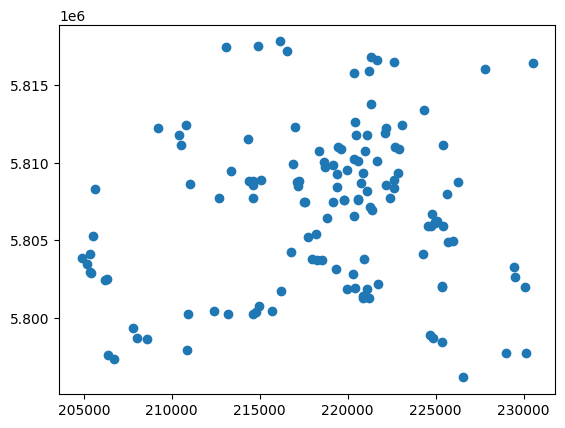

In [7]:
plt.scatter(ds_pws.x, ds_pws.y);

### Calculate distance matrix

In [8]:
distance_matrix = plg.spatial.calc_point_to_point_distances(
    ds_pws,
    ds_pws,
    # ds_pws.isel(id=slice(50, 80)), ds_pws.isel(id=slice(1, 40)),
)

In [9]:
distance_matrix

<xarray.DataArray (id: 134, id_neighbor: 134)>
array([[    0.        ,   518.79828487,   531.99603941, ...,
        28532.23134009, 25291.03668667, 25994.5064412 ],
       [  518.79828487,     0.        ,   728.38027968, ...,
        28493.8273213 , 24995.94592241, 25633.14869253],
       [  531.99603941,   728.38027968,     0.        , ...,
        28000.75903421, 24846.06853717, 25603.62271956],
       ...,
       [28532.23134009, 28493.8273213 , 28000.75903421, ...,
            0.        , 14448.29575676, 18710.76846276],
       [25291.03668667, 24995.94592241, 24846.06853717, ...,
        14448.29575676,     0.        ,  4264.61589559],
       [25994.5064412 , 25633.14869253, 25603.62271956, ...,
        18710.76846276,  4264.61589559,     0.        ]])
Coordinates:
  * id           (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
  * id_neighbor  (id_neighbor) <U6 'ams1' 'ams2' 'ams3' ... 'ams133' 'ams134'

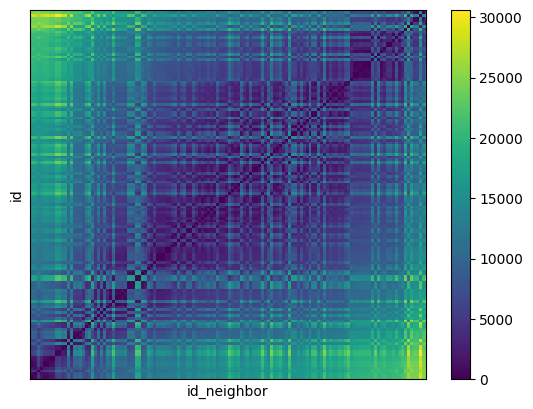

In [10]:
distance_matrix.plot()
plt.xticks([])
plt.yticks([]);

In [12]:
distance_matrix.sel(id="ams2", id_neighbor=["ams1", "ams5", "ams34"])

<xarray.DataArray (id_neighbor: 3)>
array([ 518.79828487, 1857.1349428 , 9980.37990317])
Coordinates:
    id           <U6 'ams2'
  * id_neighbor  (id_neighbor) <U6 'ams1' 'ams5' 'ams34'

In [104]:
import scipy

x_a, y_a = plg.spatial.get_point_xy(ds_pws.isel(id=slice(0, 20)))

x_b, y_b = plg.spatial.get_point_xy(ds_pws.isel(id=slice(0, 10)))

tree_a = scipy.spatial.KDTree(data=list(zip(x_a.values, y_a.values)))

distances, ixs = tree_a.query(
    list(zip(x_b.values, y_b.values)), k=20, distance_upper_bound=3000
)

distances.shape

(10, 20)

In [105]:
ixs

array([[ 0,  1,  2,  5,  6,  4,  7,  8, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20],
       [ 1,  0,  5,  6,  2,  7,  8,  4, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20],
       [ 2,  0,  1,  4,  5,  6,  8,  7, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20],
       [ 3, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20],
       [ 4,  2,  0,  1,  5,  6,  8,  7, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20],
       [ 5,  6,  1,  7,  0,  8,  2,  4, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20],
       [ 6,  5,  1,  7,  8,  0,  2,  4, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20],
       [ 7,  8,  6,  5,  1,  2,  0,  4, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20],
       [ 8,  7,  6,  5,  1,  2,  0,  4, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20],
       [ 9, 10, 12, 11, 14, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20]])

In [108]:
ds_pws.id.isel(id=slice(0, 20)).pad(id=1).isel(id=slice(1, None))

<xarray.DataArray 'id' (id: 21)>
array(['ams1', 'ams2', 'ams3', 'ams4', 'ams5', 'ams6', 'ams7', 'ams8', 'ams9',
       'ams10', 'ams11', 'ams12', 'ams13', 'ams14', 'ams15', 'ams16', 'ams17',
       'ams18', 'ams19', 'ams20', nan], dtype=object)
Coordinates:
  * id         (id) object 'ams1' 'ams2' 'ams3' 'ams4' ... 'ams19' 'ams20' nan
    elevation  (id) object 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' nan
    lat        (id) float64 52.31 52.3 52.31 52.35 ... 52.39 52.35 52.28 nan
    lon        (id) float64 4.671 4.675 4.677 4.678 ... 4.75 4.757 4.762 nan
    x          (id) float64 2.049e+05 2.052e+05 2.054e+05 ... 2.109e+05 nan
    y          (id) float64 5.804e+06 5.803e+06 5.804e+06 ... 5.8e+06 nan

In [107]:
ds_pws.id.isel(id=slice(0, 20)).pad(id=1).data[ixs]

array([[nan, 'ams1', 'ams2', 'ams5', 'ams6', 'ams4', 'ams7', 'ams8',
        'ams20', 'ams20', 'ams20', 'ams20', 'ams20', 'ams20', 'ams20',
        'ams20', 'ams20', 'ams20', 'ams20', 'ams20'],
       ['ams1', nan, 'ams5', 'ams6', 'ams2', 'ams7', 'ams8', 'ams4',
        'ams20', 'ams20', 'ams20', 'ams20', 'ams20', 'ams20', 'ams20',
        'ams20', 'ams20', 'ams20', 'ams20', 'ams20'],
       ['ams2', nan, 'ams1', 'ams4', 'ams5', 'ams6', 'ams8', 'ams7',
        'ams20', 'ams20', 'ams20', 'ams20', 'ams20', 'ams20', 'ams20',
        'ams20', 'ams20', 'ams20', 'ams20', 'ams20'],
       ['ams3', 'ams20', 'ams20', 'ams20', 'ams20', 'ams20', 'ams20',
        'ams20', 'ams20', 'ams20', 'ams20', 'ams20', 'ams20', 'ams20',
        'ams20', 'ams20', 'ams20', 'ams20', 'ams20', 'ams20'],
       ['ams4', 'ams2', nan, 'ams1', 'ams5', 'ams6', 'ams8', 'ams7',
        'ams20', 'ams20', 'ams20', 'ams20', 'ams20', 'ams20', 'ams20',
        'ams20', 'ams20', 'ams20', 'ams20', 'ams20'],
       ['ams5', 'ams

In [103]:
distances

array([[   0.        ,  518.79828487,  531.99603941, 1053.69341611,
        1143.27175637, 1511.58513191, 1978.42407688, 2011.43076108,
                  inf,           inf,           inf,           inf,
                  inf,           inf,           inf,           inf,
                  inf,           inf,           inf,           inf],
       [   0.        ,  518.79828487,  536.57331581,  628.2617951 ,
         728.38027968, 1473.72603665, 1517.54109781, 1857.1349428 ,
                  inf,           inf,           inf,           inf,
                  inf,           inf,           inf,           inf,
                  inf,           inf,           inf,           inf],
       [   0.        ,  531.99603941,  728.38027968, 1133.17049647,
        1188.96880534, 1284.99967211, 1918.32049363, 1922.55971129,
                  inf,           inf,           inf,           inf,
                  inf,           inf,           inf,           inf,
                  inf,           inf,         

In [109]:
ds_closest_neigbors = xr.Dataset(
    data_vars={
        "distance": (("id", "n_closest"), distances),
        "neigbor_id": (("id", "n_closest"), ds_pws.id.data[ixs]),
    }
)
ds_closest_neigbors

<xarray.Dataset>
Dimensions:     (id: 10, n_closest: 20)
Dimensions without coordinates: id, n_closest
Data variables:
    distance    (id, n_closest) float64 0.0 518.8 532.0 ... inf inf inf
    neigbor_id  (id, n_closest) <U6 'ams1' 'ams2' 'ams3' ... 'ams21' 'ams21'

In [201]:
closest_neigbors = plg.spatial.get_closest_points_to_point(
    ds_points=ds_pws.isel(id=slice(0, 30)),
    ds_points_neighbors=ds_pws,
    max_distance=5e3,
    n_closets=20,
)
closest_neigbors

<xarray.Dataset>
Dimensions:      (id: 30, n_closest: 20)
Coordinates:
  * id           (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams28' 'ams29' 'ams30'
    elevation    (id) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    lat          (id) float64 52.31 52.3 52.31 52.35 ... 52.38 52.36 52.43 52.36
    lon          (id) float64 4.671 4.675 4.677 4.678 ... 4.805 4.805 4.809
    x            (id) float64 2.049e+05 2.052e+05 ... 2.149e+05 2.146e+05
    y            (id) float64 5.804e+06 5.803e+06 ... 5.818e+06 5.809e+06
Dimensions without coordinates: n_closest
Data variables:
    distance     (id, n_closest) float64 0.0 518.8 532.0 ... 4.22e+03 4.691e+03
    neighbor_id  (id, n_closest) object 'ams1' 'ams2' 'ams3' ... 'ams41' 'ams58'

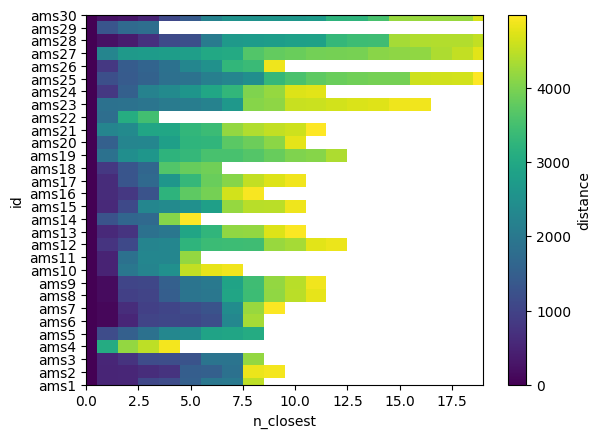

In [202]:
closest_neigbors.distance.plot();

### Select a PWS and plot distance of neighbors

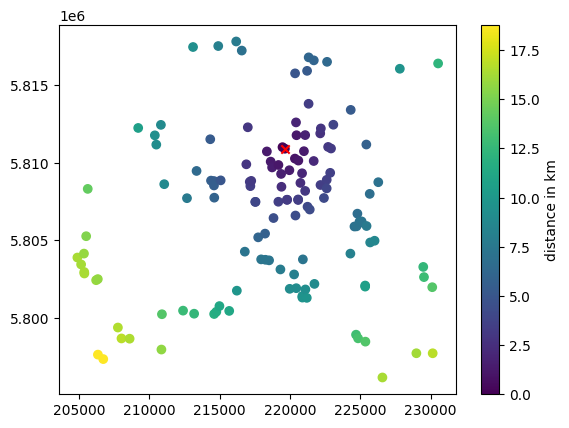

In [11]:
pws_id = "ams63"

sc = plt.scatter(ds_pws.x, ds_pws.y, c=distance_matrix.sel(id=pws_id) / 1e3)
plt.scatter(ds_pws.sel(id=pws_id).x, ds_pws.sel(id=pws_id).y, c="r", marker="x")
plt.colorbar(sc, label="distance in km");

### Select neighbors within certain range

In [12]:
pws_id = "ams63"

max_distance = 3e3  # this is in meteres

distances = distance_matrix.sel(id=pws_id)
selected_neighbor_ids = ds_pws.id.data[distances < max_distance]
selected_neighbor_ids

array(['ams41', 'ams42', 'ams51', 'ams54', 'ams55', 'ams58', 'ams60',
       'ams61', 'ams62', 'ams63', 'ams67', 'ams69', 'ams70', 'ams71',
       'ams74', 'ams78', 'ams80', 'ams83', 'ams84', 'ams94', 'ams96',
       'ams97'], dtype='<U6')

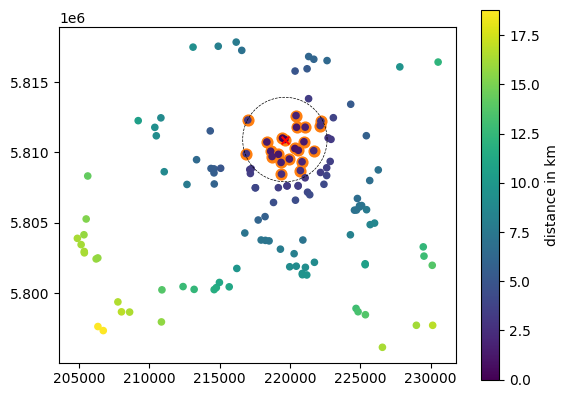

In [13]:
fig, ax = plt.subplots()
ax.scatter(
    ds_pws.x.sel(id=selected_neighbor_ids),
    ds_pws.y.sel(id=selected_neighbor_ids),
    c="C1",
    s=60,
)
sc = ax.scatter(ds_pws.x, ds_pws.y, c=distance_matrix.sel(id=pws_id) / 1e3, s=20)
ax.scatter(ds_pws.sel(id=pws_id).x, ds_pws.sel(id=pws_id).y, c="r", s=30, marker="x")
plt.colorbar(sc, label="distance in km")
ax.set_aspect("equal")

# Plot a circel with max_distance to see if the selections fits
an = np.linspace(0, 2 * np.pi, 100)
ax.plot(
    ds_pws.x.sel(id=pws_id).data + max_distance * np.cos(an),
    ds_pws.y.sel(id=pws_id).data + max_distance * np.sin(an),
    color="k",
    linestyle="--",
    linewidth=0.5,
);